In [1]:
from vae import cvae, dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


/home/hubert/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# load data

ht1a_path = './VAE_data/5ht1a_klek_balanced.parquet'
ht7_path = './VAE_data/5ht7_klek_balanced.parquet'
beta2_path = './VAE_data/beta2_klek_balanced.parquet'
d2_path = './VAE_data/d2_klek_balanced.parquet'
h1_path = './VAE_data/h1_klek_balanced.parquet'

train_dataset = dataset.VAEDataset(d2_path)

from torch.utils.data import DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

### CVAE

In [9]:
# define parameters

latent_size = 8
input_size = 4860
learning_rate = 0.0001

# init model

model = cvae.CVAE(input_size=input_size, latent_size=latent_size).to(device)

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

def train_CVAE(model, train_dataloader, learning_rate, epochs=40, device=device, plot_loss=False):
    
    criterion = cvae.VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    sheduler = ReduceLROnPlateau(optimizer, 'min', patience=25, verbose=True)
    losses = []
    
    if plot_loss:
        fig, ax = plt.subplots()
        dh = display(fig, display_id=True)

    for epoch in tqdm(range(1, epochs+1)):
        for (fp, y) in train_dataloader:
            fp = fp.to(device)
            y = y.to(device)
            encoded, mu, logvar = model(fp, y)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sheduler.step(loss)
        losses.append(loss.item())
        if plot_loss:
            ax.clear()
            ax.plot(losses)
            ax.set_title(f'Epoch {epoch}, Loss: {loss.item():.2f}')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_yscale('log')
            dh.update(fig)
            
    return model, losses

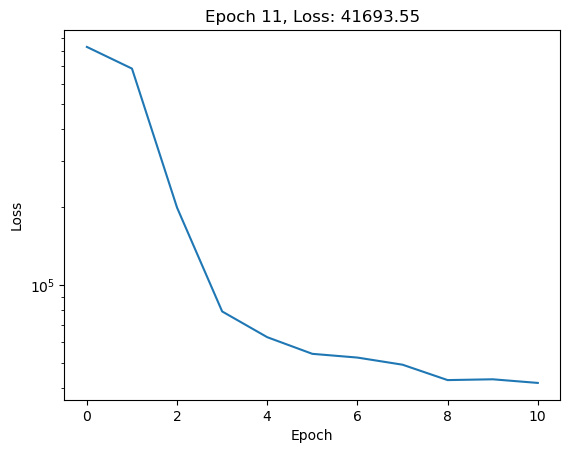

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

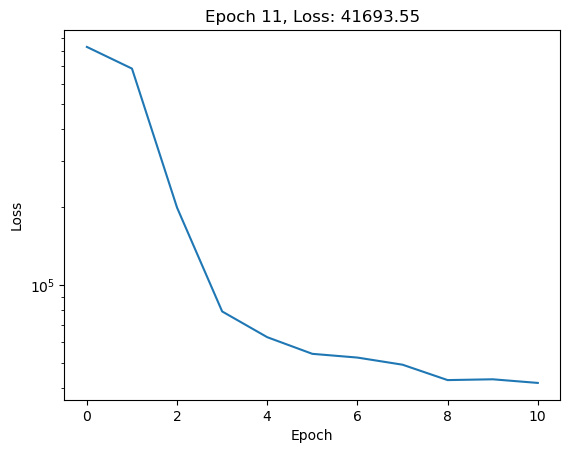

In [11]:
cvae, losses = train_CVAE(model, train_dataloader, learning_rate, 
                          epochs=50, device=device, plot_loss=True)

In [12]:
# encode all data into latent space

encoded_cvae = []
for (fp, y) in train_dataloader:
    fp = fp.to(device)
    y = y.to(device)
    mu, logvar = cvae.encoder(fp, y)
    enc = cvae.reparameterize(mu, logvar)
    encoded_cvae.append(enc.detach().cpu().numpy())

Text(0, 0.5, 'PC2')

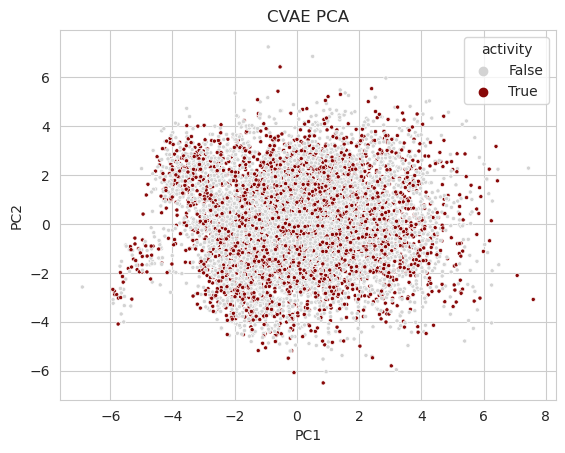

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# plot PCA

cvae_pca = PCA(n_components=2)
cvae_pca_results = cvae_pca.fit_transform(np.concatenate(encoded_cvae))
cvae_pca_results = pd.DataFrame(cvae_pca_results)
cvae_pca_results['activity'] = activity

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=cvae_pca_results, marker='.', palette=colors)
plt.title('CVAE PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 't-SNE 2')

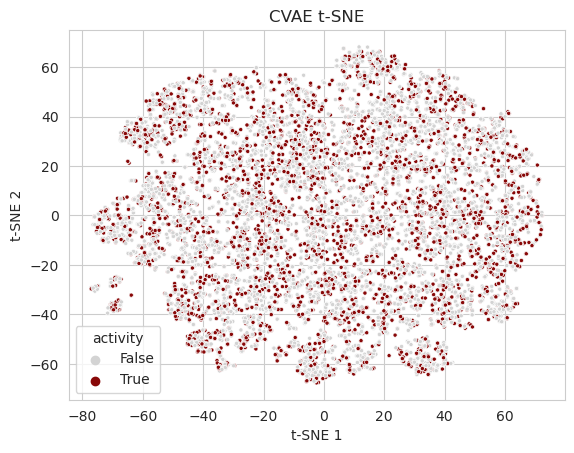

In [15]:
# plot t-SNE

cvae_tsne = TSNE(n_components=2, perplexity=20, learning_rate=100)
cvae_tsne_results = cvae_tsne.fit_transform(np.concatenate(encoded_cvae))
cvae_tsne_results = pd.DataFrame(cvae_tsne_results)
cvae_tsne_results['activity'] = activity

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=cvae_tsne_results, marker='.', palette=colors)
plt.title('CVAE t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

In [16]:
from vae.cvae import sample_CVAE

In [17]:
artificial_active = sample_CVAE(model=cvae, n_samples=100, device=device, active=True)

# convert to binary
artificial_active[artificial_active >= 0.5] = 1
artificial_active[artificial_active < 0.5] = 0

real_active = fp_train[activity == 1].detach().cpu().numpy()
real_active_bits = np.where(real_active == 1)[1]
artificial_active_bits = np.where(artificial_active == 1)[1]

# compare top 10 most frequent bits
from collections import Counter
real_active_freq = Counter(real_active_bits)
artificial_active_freq = Counter(artificial_active_bits)
print('Bits in top 10 most frequent bits:')
print(f'real_active bits: {real_active_freq.most_common(10)}')
print(f'artificial_active bits: {artificial_active_freq.most_common(10)}')

Bits in top 10 most frequent bits:
real_active bits: [(948, 3691), (81, 3690), (1048, 3687), (1292, 3685), (1376, 3685), (1490, 3685), (1312, 3670), (1403, 3670), (105, 3613), (1319, 3550)]
artificial_active bits: [(81, 100), (105, 100), (247, 100), (744, 100), (948, 100), (1048, 100), (1292, 100), (1293, 100), (1294, 100), (1312, 100)]


In [19]:
artificial_in_real = {k:v for k,v in sorted(artificial_in_real.items(), key=lambda x: x[0])}
artificial_active_freq = {k:v for k,v in sorted(artificial_active_freq.items(), key=lambda x: x[0])}

In [21]:
df = pd.DataFrame()
df['bit'] = artificial_in_real.keys()
df['artificial_freq'] = artificial_in_real.values()
df['real_freq'] = artificial_active_freq.values()
df['difference'] = df['artificial_freq'] - df['real_freq']
df['bit'] = df['bit'].astype('category')
df.describe()

,artificial_freq,real_freq,difference
count,98.000000,98.000000,98.000000
mean,0.595941,0.402959,0.192982
std,0.410875,0.424726,0.354318
min,0.024346,0.010000,-0.667384
25%,0.267624,0.012500,0.036512
50%,0.527980,0.145000,0.258169
75%,0.802961,0.917500,0.356806
max,1.341206,1.000000,0.972064


In [22]:
alt_df = pd.melt(df, id_vars=['bit'], value_vars=['artificial_freq', 'real_freq'], var_name='type', value_name='frequency')
alt_df

,bit,type,frequency
0,0,artificial_freq,0.649346
1,81,artificial_freq,1.340843
2,82,artificial_freq,0.632631
3,105,artificial_freq,1.312863
4,107,artificial_freq,0.761628
...,...,...,...
191,1573,real_freq,0.600000
192,1574,real_freq,0.010000
193,1585,real_freq,0.770000
194,1592,real_freq,0.990000


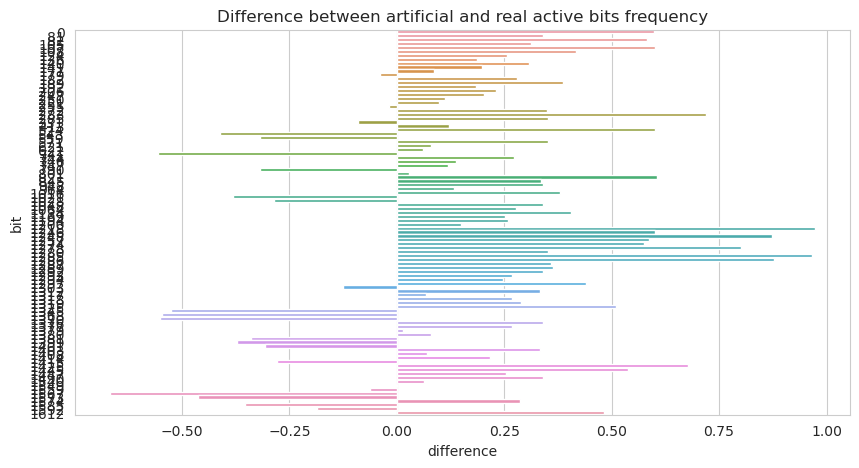

In [23]:
# create twoside vertical barplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='difference', y='bit', data=df, ax=ax)
ax.title.set_text('Difference between artificial and real active bits frequency')

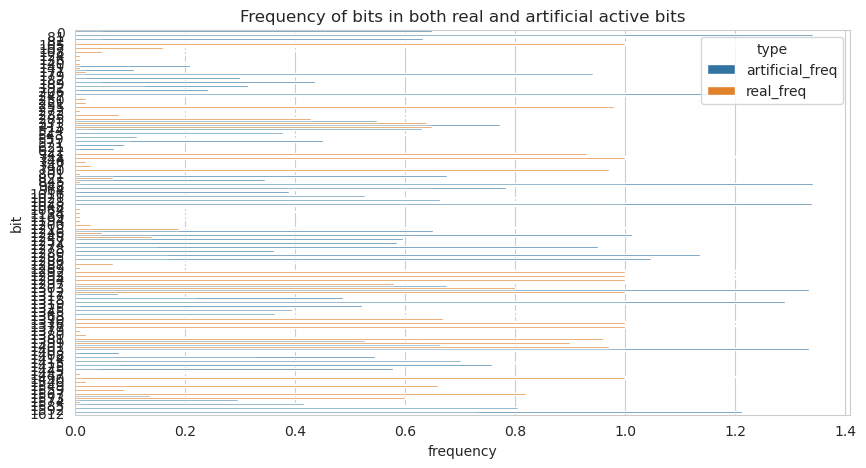

In [24]:
# plot frequency of bits in both real and artificial active bits one next to another
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(y='bit', x='frequency', hue='type', data=alt_df, ax=ax)
ax.title.set_text('Frequency of bits in both real and artificial active bits')
